In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam

import yfinance as yf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = yf.download('spy', start='2010-01-05')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-05,113.260002,113.680000,112.849998,113.629997,91.030411,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,91.094490,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,91.479050,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,91.783432,126402800
2010-01-11,115.080002,115.129997,114.239998,114.730003,91.911636,106375700


In [3]:
data = df.Close.values
dim = data.shape[0]

X = np.arange(0,dim)
y = data 

SS =  MinMaxScaler() #StandardScaler()
y_normalized = SS.fit_transform(y.reshape(-1,1)) # not used 

print(data.shape)

(2847,)


In [4]:
# checkpoint_filepath = '/tmp/checkpoint' # model.load_weights(checkpoint_filepath)
# MC = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,
#                       monitor='loss', mode='max', save_best_only=True)

In [29]:
nodes = 100

model = Sequential()
model.add(Dense(nodes*3, 'elu', input_shape=(1,)))
# model.add(LayerNormalization())
model.add(BatchNormalization())

model.add(Dense(nodes, 'elu'))
model.add(GaussianNoise(0.5))

model.add(Dense(10, 'elu'))
model.add(Dense(1))

model.compile(optimizer=Adam(), loss ='mse') # mae # 0.00005

epochs = 200
ES = EarlyStopping(monitor='val_loss', patience=epochs/10, restore_best_weights= True)
model.fit(X, y, batch_size= 50, epochs= epochs, callbacks= [ES], validation_split= 0.10)

Epoch 1/200
52/52 [==============================] - 1s 4ms/step - loss: 41609.4455 - val_loss: 25816.2344
Epoch 2/200
52/52 [==============================] - 0s 2ms/step - loss: 25934.4098 - val_loss: 78903.5547
Epoch 3/200
52/52 [==============================] - 0s 2ms/step - loss: 9862.2616 - val_loss: 10023.9697
Epoch 4/200
52/52 [==============================] - 0s 2ms/step - loss: 4829.7413 - val_loss: 5840.9404
Epoch 5/200
52/52 [==============================] - 0s 2ms/step - loss: 2008.5996 - val_loss: 1666.6606
Epoch 6/200
52/52 [==============================] - 0s 2ms/step - loss: 1466.3095 - val_loss: 1637.9790
Epoch 7/200
52/52 [==============================] - 0s 2ms/step - loss: 1080.4587 - val_loss: 1809.1608
Epoch 8/200
52/52 [==============================] - 0s 2ms/step - loss: 1123.5968 - val_loss: 3865.1262
Epoch 9/200
52/52 [==============================] - 0s 2ms/step - loss: 915.9844 - val_loss: 1257.2032
Epoch 10/200
52/52 [==============================]

(2847, 1)
[[106.44472 ]
 [106.007286]
 [105.62753 ]
 [105.2982  ]
 [105.010956]]


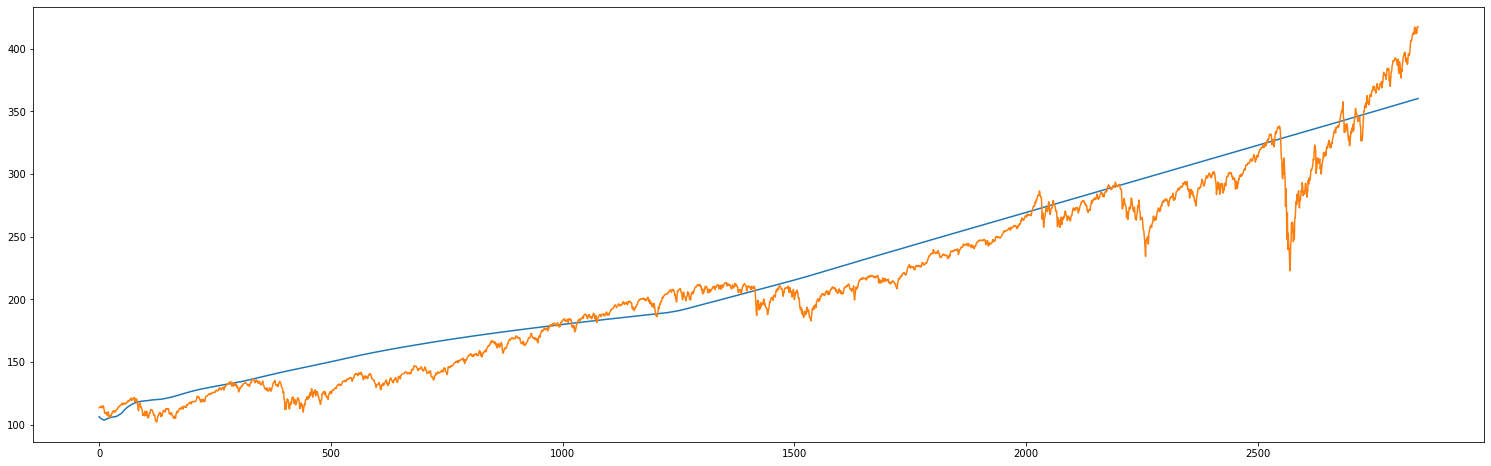

In [30]:
y_hat = model.predict(X)
print(y_hat.shape)
print(y_hat[:5])

plt.figure(figsize=(26, 8))
plt.plot(y_hat)
plt.plot(y)

## This code is old, don't trust my preprocessing is correct 

In [35]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length]
        dataX.append(_x)
    return np.array(dataX)

tmp = MinMaxScaler().fit_transform(X.reshape(-1, 1))
tmp.reshape(1,-1)[0]

X_lstm = build_dataset(tmp,20)
X_lstm = X_lstm.reshape((X_lstm.shape[0], 1, X_lstm.shape[1]))
dim = X_lstm.shape[0]

y_lstm = y[0:] # was y[20:] 
mm = MinMaxScaler()
y_lstm = mm.fit_transform(y_lstm.reshape(-1, 1))
y_lstm = y_lstm.reshape(1,-1)[0]

y_lstm = y_lstm[20:] 
y_lstm

array([0.02419075, 0.01344284, 0.01414035, ..., 0.9972417 , 1.        ,
       0.99977814])

In [36]:
print(X_lstm.shape)
print(len(y_lstm))
print(dim)

(2827, 1, 20)
2827
2827


In [37]:
nodes = 1000
model = Sequential()

model.add(LSTM(nodes, input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model.add(BatchNormalization())
model.add(Dense(nodes, 'elu')) 

model.add(Dense(nodes, 'elu')) 
model.add(Dense(nodes/2, 'elu'))

model.add(Dense(100, 'elu'))
model.add(Dense(1))

model.compile(optimizer=Adam(), loss ='mse') # mae # 0.0005

epochs = 20
ES = EarlyStopping(monitor='loss', patience=epochs/2, restore_best_weights= True)
model.fit(X_lstm, y_lstm, batch_size= 16, epochs= epochs, callbacks= [ES]) #  

Epoch 1/20
177/177 [==============================] - 7s 32ms/step - loss: 2.1623
Epoch 2/20
177/177 [==============================] - 6s 33ms/step - loss: 0.0060
Epoch 3/20
177/177 [==============================] - 6s 31ms/step - loss: 0.0065
Epoch 4/20
177/177 [==============================] - 6s 32ms/step - loss: 0.0075
Epoch 5/20
177/177 [==============================] - 6s 32ms/step - loss: 0.0058
Epoch 6/20
177/177 [==============================] - 6s 32ms/step - loss: 0.0051
Epoch 7/20
177/177 [==============================] - 6s 32ms/step - loss: 0.0059
Epoch 8/20
177/177 [==============================] - 6s 32ms/step - loss: 0.0046
Epoch 9/20
177/177 [==============================] - 6s 32ms/step - loss: 0.0052
Epoch 10/20
177/177 [==============================] - 6s 32ms/step - loss: 0.0045
Epoch 11/20
177/177 [==============================] - 6s 32ms/step - loss: 0.0051
Epoch 12/20
177/177 [==============================] - 6s 33ms/step - loss: 0.0048
Epoch 13/20
1

array([[-0.02442195],
       [-0.02425542],
       [-0.02408878],
       ...,
       [ 0.83250093],
       [ 0.83296716],
       [ 0.8334333 ]], dtype=float32)

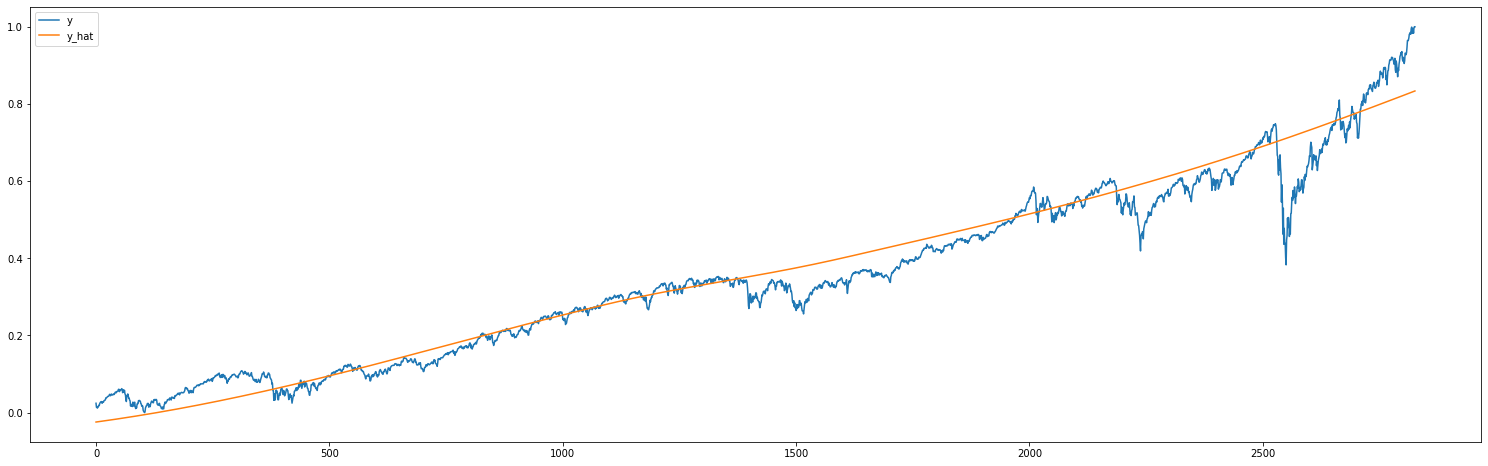

In [38]:
y_hat = model.predict(X_lstm)
# y_hat = y_hat.reshape(1,-1)[0]
# y_hat *= -1
# y_hat += 0.7

plt.figure(figsize=(26,8))
plt.plot(y_lstm, label = 'y')
plt.plot(y_hat, label = 'y_hat')
plt.legend()
y_hat

In [93]:
nodes = 100
model = Sequential()

# model.add(LSTM(1000, input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model.add(TimeDistributed(Dense(nodes))) # , input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
# model.add(BatchNormalization())

# model.add(TimeDistributed(Dense(nodes))) 

model.add(Dense(nodes/2, 'elu'))
model.add(GaussianNoise(0.5))
# model.add(Dense(nodes/2, 'elu'))

model.add(Dense(nodes/10, 'elu'))
model.add(Dense(1))

model.compile(optimizer=Adam(), loss ='mse') # mae # 0.0005

epochs = 300 # High epochs very high batch_size works well
ES = EarlyStopping(monitor='loss', patience=epochs/50, restore_best_weights= True)
model.fit(X_lstm, y_lstm, batch_size= 5000, epochs= epochs, callbacks= [ES]) # , validation_split=0.1)  

Epoch 1/300
1/1 [==============================] - 0s 403ms/step - loss: 0.6671
Epoch 2/300
1/1 [==============================] - 0s 5ms/step - loss: 0.4617
Epoch 3/300
1/1 [==============================] - 0s 7ms/step - loss: 0.4680
Epoch 4/300
1/1 [==============================] - 0s 6ms/step - loss: 0.4662
Epoch 5/300
1/1 [==============================] - 0s 6ms/step - loss: 0.4582
Epoch 6/300
1/1 [==============================] - 0s 6ms/step - loss: 0.4100
Epoch 7/300
1/1 [==============================] - 0s 6ms/step - loss: 0.4017
Epoch 8/300
1/1 [==============================] - 0s 6ms/step - loss: 0.3487
Epoch 9/300
1/1 [==============================] - 0s 6ms/step - loss: 0.3390
Epoch 10/300
1/1 [==============================] - 0s 6ms/step - loss: 0.3245
Epoch 11/300
1/1 [==============================] - 0s 5ms/step - loss: 0.3149
Epoch 12/300
1/1 [==============================] - 0s 5ms/step - loss: 0.3145
Epoch 13/300
1/1 [==============================] - 0s 5ms/

array([0.02993071, 0.03009118, 0.03025214, ..., 0.74298334, 0.7432115 ,
       0.7434397 ], dtype=float32)

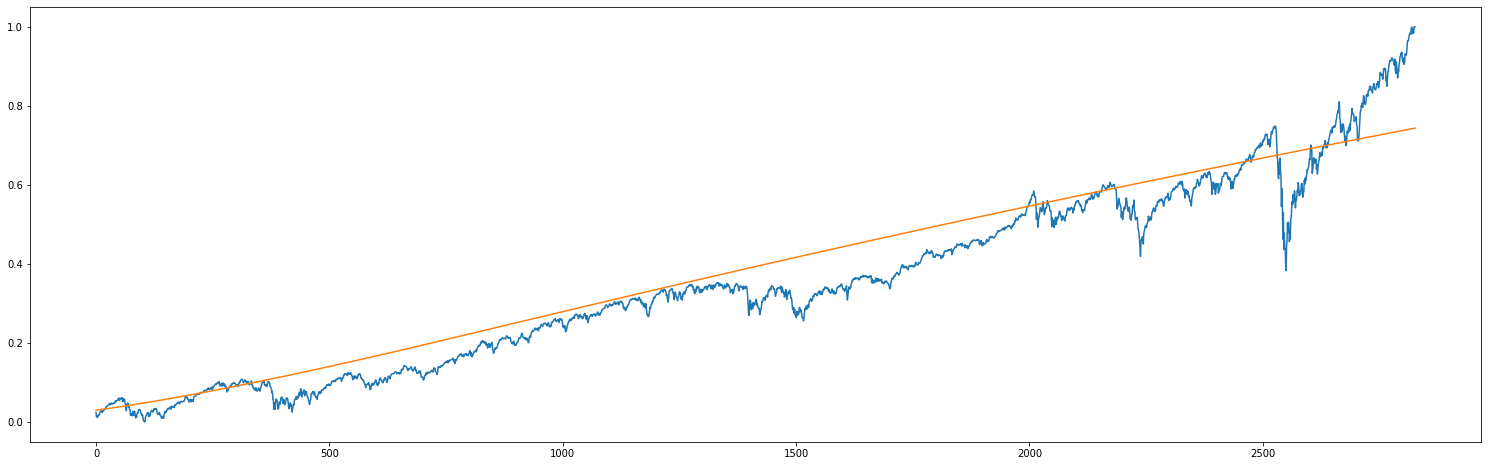

In [95]:
y_hat = model.predict(X_lstm)
y_hat = y_hat.reshape(1,-1)[0]


plt.figure(figsize=(26,8))
plt.plot(y_lstm)
plt.plot(y_hat)
y_hat

In [41]:
model.evaluate(X_lstm,y_lstm)

89/89 [==============================] - 0s 3ms/step - loss: 0.0487


0.048712488263845444

In [42]:
# y_normalized